In [95]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline

In [96]:
def process_sensor_data(file_path, Hz = 50):
    # path = "/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/Ezra/"

    Hz =50
    """
    This function processes sensor data from accelerometer, gyroscope, and linear accelerometer CSV files.

    Parameters:
    file_path (str): The path to the directory containing the CSV files. The directory should contain 'Accelerometer.csv', 'Gyroscope.csv', and 'Linear Accelerometer.csv'.

    Returns:
    df_interpolated (DataFrame): A DataFrame containing the interpolated sensor data. The DataFrame is indexed by time in seconds, and each column corresponds to a sensor reading.

    The function first reads the data from the CSV files and sets the time as the index. It then joins the data from the three files into a single DataFrame, sorting by time.
    The function then creates a new DataFrame to hold the interpolated data. It uses cubic spline interpolation to fill in any missing values in the sensor data.
    """

    accel = pd.read_csv(file_path+ "Accelerometer.csv").set_index("Time (s)")
    accel.columns = ["Accel X (m/s^2)", "Accel Y (m/s^2)", "Accel Z (m/s^2)"]
    gyro = pd.read_csv(file_path+ "Gyroscope.csv").set_index("Time (s)")
    gyro.columns = ["Gyro X (m/s^2)", "Gyro Y (m/s^2)", "Gyro Z (m/s^2)"]
    linear_accel = pd.read_csv(file_path+ "Linear Accelerometer.csv").set_index("Time (s)")
    linear_accel.columns = ["Lin Accel X (m/s^2)", "Lin Accel Y (m/s^2)", "Lin Accel Z (m/s^2)"]

    times = np.array(list(range(1, int(max(gyro.index.values)) * Hz))) / Hz

    df = accel.join(gyro, on="Time (s)", how="outer", rsuffix="_gyro").join(linear_accel, on="Time (s)", how="outer", rsuffix="_lin").set_index("Time (s)").sort_index()

    df_interpolated = pd.DataFrame(index=pd.Series(times, name="Time (s)"), columns=df.columns, data=np.zeros((times.shape[0], df.shape[1]))*np.nan)

    for col in df.columns:
        _values = df[col].values
        idx = np.isnan(_values)
        cs = CubicSpline(df.index.values[~idx], _values[~idx])
        df_interpolated[col] = cs(times)

    maxTime = 42 * 60 * Hz
    postureInterval = 2 * 60 * Hz
    transTime = 10  

    end_of_experiment_time = maxTime + transTime * Hz
    # Remove data after experiment is done
    df_interpolated = df_interpolated.iloc[df_interpolated.index.get_level_values(0) < (42*60 + 10)].sort_index()

    # Label order of experiment
    labelOrder = ['L', 'R', 'L', 'F', 'L', 'B', 'L', 'S', 'R', 'F', 'R', 'B', 'R', 'S', 'F', 'B', 'F', 'S', 'B', 'S', 'L']

    # Set start times of transitions and labels, with 10 second time for transitions
    transPos = [i for i in range(0, len(df_interpolated), postureInterval)][:-1]
    labelPos = [time + transTime * Hz for time in transPos]

    transPos , len(df_interpolated)

    # Set labels
    labels = np.chararray(len(df_interpolated), unicode = True)
    for i, _times in enumerate(zip(transPos, labelPos)):
        # print(len(labels))
        labels[_times[0]:] = 'T'
        labels[_times[1]:] = labelOrder[i]
        
    df_interpolated["Label"] = labels

    return df_interpolated

In [97]:
# open the folder named Data and get the names of the files
path = "/Users/alexanderithakis/Documents/GitHub/ML4QS/Python3Code/Data/"
files = os.listdir(path)


dfs = []
for _file in files:
    if _file[0] == '.': continue
    _df = process_sensor_data(path + _file + '/')
    # add to the _df a row with the name of the file which is going to be added to the index, so the index will have 2 levels
    _df = _df.assign(Participant = _file)
    _df = _df.set_index('Participant', append=True)
    dfs.append(_df)
    # break

dfs = pd.concat(dfs)
dfs

Accel X (m/s^2)  Accel Y (m/s^2)  Accel Z (m/s^2)  \
Time (s) Participant                                                      
0.02     Ezra               -6.695648         6.425763         2.890562   
0.04     Ezra               -7.306077         6.184132         3.166081   
0.06     Ezra               -7.165934         6.242556         3.196803   
0.08     Ezra               -7.057753         6.326050         3.187511   
0.10     Ezra               -6.914651         6.259296         3.146490   
...                               ...              ...              ...   
2523.90  Sjors              -2.563917         9.418729         2.101827   
2523.92  Sjors              -2.239452         9.239055         2.222676   
2523.94  Sjors              -2.192481         9.256724         2.210018   
2523.96  Sjors              -2.325050         9.284401         2.213467   
2523.98  Sjors              -2.372463         9.256119         2.192386   

                      Gyro X (m/s^2)  Gyro Y (m/s^2)  Gyro Z (m/s^2)  \
Time (s) Participant                                                   
0.02     Ezra              -0.031204        0.219063       -0.027557   
0.04     Ezra              -0.004081        0.102260       -0.025153   
0.06     Ezra               0.002151        0.016317       -0.007400   
0.08     Ezra               0.018974       -0.003981        0.014050   
0.10     Ezra               0.025652        0.005295        0.024584   
...                              ...             ...             ...   
2523.90  Sjors              0.013782       -0.060343        0.017629   
2523.92  Sjors              0.012139       -0.075650       -0.037158   
2523.94  Sjors              0.011882       -0.050519       -0.067697   
2523.96  Sjors              0.009226       -0.024324       -0.071850   
2523.98  Sjors              0.005410       -0.031199       -0.070311   

                      Lin Accel X (m/s^2)  Lin Accel Y (m/s^2)  \
Time (s) Participant                                             
0.02     Ezra                    0.266295             0.195861   
0.04     Ezra                   -0.405272            -0.160486   
0.06     Ezra                   -0.393979            -0.133335   
0.08     Ezra                   -0.248121            -0.018309   
0.10     Ezra                   -0.127193            -0.097493   
...                                   ...                  ...   
2523.90  Sjors                  -0.332171             0.134921   
2523.92  Sjors                   0.014699            -0.027746   
2523.94  Sjors                   0.082193            -0.047331   
2523.96  Sjors                  -0.025103             0.009627   
2523.98  Sjors                  -0.055141            -0.034242   

                      Lin Accel Z (m/s^2) Label  
Time (s) Participant                             
0.02     Ezra                   -0.270117     T  
0.04     Ezra                    0.070983     T  
0.06     Ezra                    0.127672     T  
0.08     Ezra                    0.139324     T  
0.10     Ezra                    0.100887     T  
...                                   ...   ...  
2523.90  Sjors                  -0.077430     L  
2523.92  Sjors                   0.028434     L  
2523.94  Sjors                   0.027077     L  
2523.96  Sjors                   0.023703     L  
2523.98  Sjors                   0.018467     L  

[378947 rows x 10 columns]

In [ ]:
colors = np.zeros(len(df_interpolated), dtype = "<U10")
colDict = {"T": "black", "R": "green", "L": "yellow", "B": "blue", "S": "red", "F": "turquoise"}

# Function to segment the data by continuous label
def segment_data(df):
    segments = []
    current_label = df.iloc[0]['Label']
    start_idx = 0
    for idx in range(1, len(df)):
        if df.iloc[idx]['Label'] != current_label:
            segments.append(df[start_idx:idx])
            start_idx = idx
            current_label = df.iloc[idx]['Label']
    segments.append(df[start_idx:])  # add the last segment
    return segments


segments = segment_data(df_interpolated.reset_index())

# Create the plot
fig = go.Figure()

# New order for labels
newLabOrder = []
for label in labelOrder:
    newLabOrder.append('T')
    newLabOrder.append(label)

# Add each segment as a separate trace
legend_added = set()
for i, segment in enumerate(segments):
    label = newLabOrder[i]
    show_legend = label not in legend_added
    fig.add_trace(go.Scatter(
        x = segment['Time (s)'],
        y = segment['Accel X (m/s^2)'],
        mode = 'lines',
        name = label,
        line = {
            "color": colDict[label]
        },
        showlegend = show_legend
    )),
    legend_added.add(label)

# Update layout
fig.update_layout(
    title = "Smartphone Accelerometer Time Series for Different Postures",
    xaxis_title = "Time (min)",
    yaxis_title = "Acceleration X (m/s^2)"
)
# update the size of the plot so it looks good on overleaf
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
)

# for i in range(0, maxTime + postureInterval, postureInterval):
#     fig.add_vline(x = i + transTime * Hz  , line_dash="dash")

# Show the plot
fig.show()

---------------------
# **Feature Engineering**

<Axes: title={'center': 'Accel X (m/s^2) before and after preprocessing - Lowpass Filter (cutoff=0.01, fs=1.0, order=5)'}, xlabel='Time (s),Participant'>

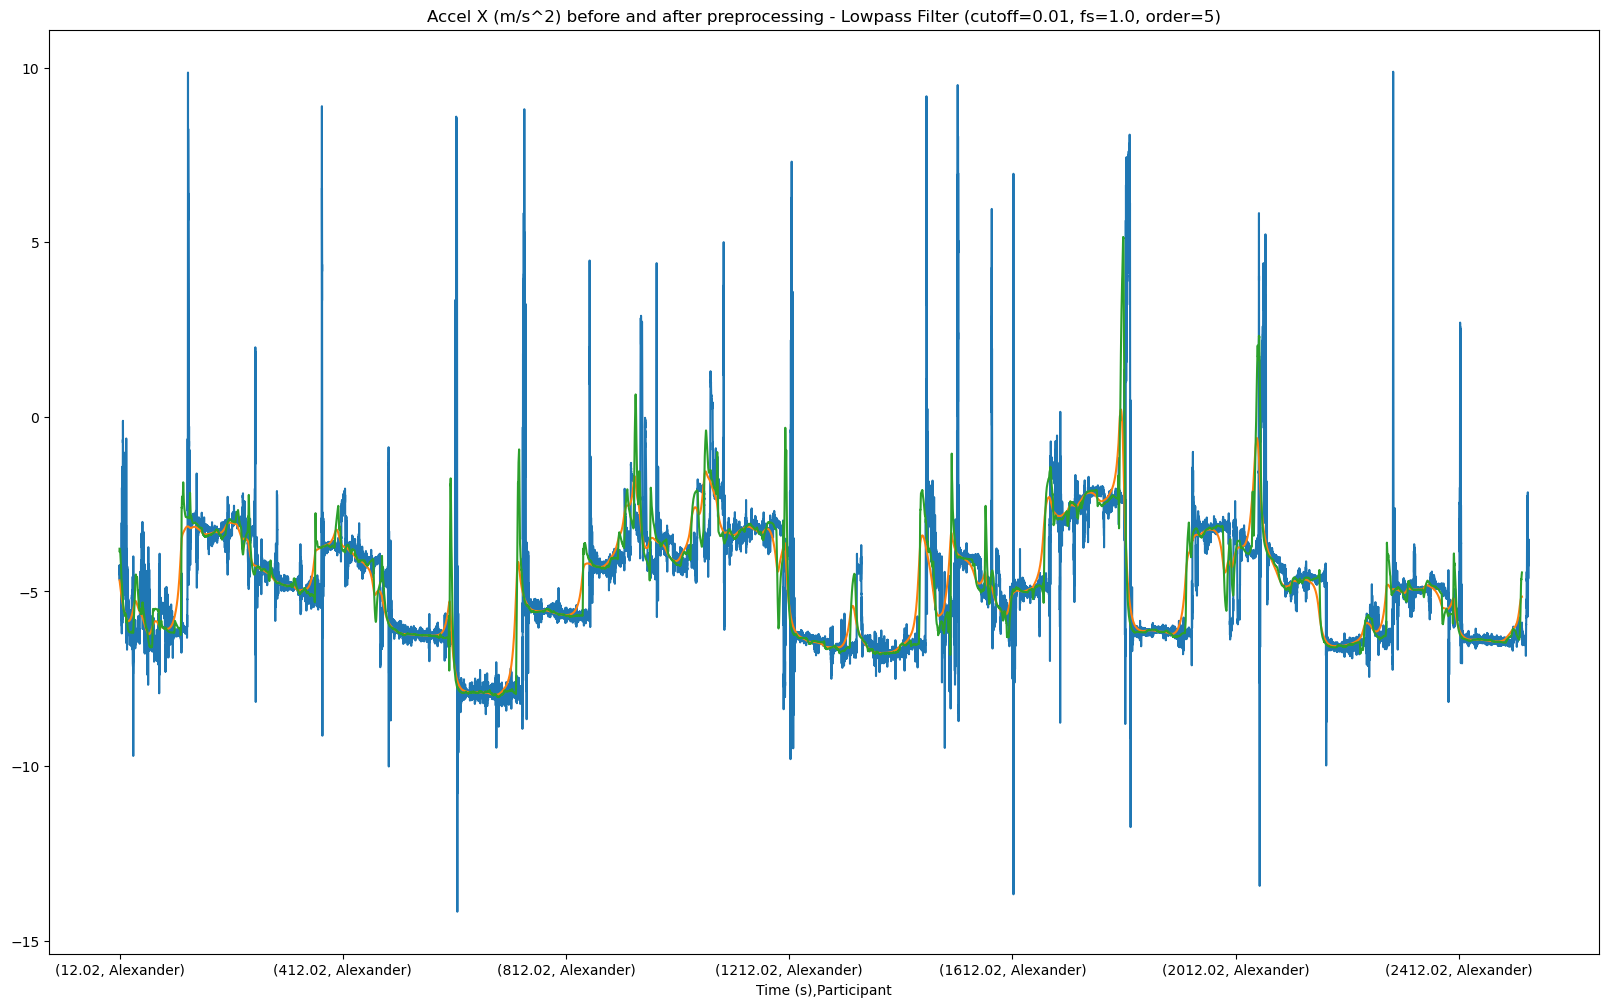

In [156]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from scipy.signal import butter, filtfilt

class LowpassFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff=0.5, fs=1.0, order=5):
        self.cutoff = cutoff
        self.fs = fs
        self.order = order
    
    def lowpassFilter(self, data):
        nyq = 0.5 * self.fs
        normal_cutoff = self.cutoff / nyq
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_filtered = X.copy()
        for column in X.columns:
            X_filtered[column + '_LP'] = self.lowpassFilter(X[column])
        return X_filtered


class LOFOutlierMarker(BaseEstimator, TransformerMixin):
    def __init__(self, algorithm='kd_tree', n_neighbors=20):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm 
    
    def fit(self, X, y=None):
        self.lof = LocalOutlierFactor(algorithm=self.algorithm, n_neighbors=self.n_neighbors)
        return self
    
    def transform(self, X, y=None):
        X_marked = X.copy()
        outliers = self.lof.fit_predict(X_marked) == -1
        X_marked[outliers] = np.nan
        return X_marked


class CubicSplineInterpolator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_interpolated = X.copy()
 
        nan_idx = X_interpolated.isna().sum(axis=1).astype(bool).values
        times = X_interpolated.index.get_level_values(0)
        for column in X.columns:
            if len(nan_idx) > 0:
                cs = CubicSpline(times[~nan_idx], X_interpolated[column].iloc[~nan_idx])
                X_interpolated.loc[nan_idx, column] = cs(times[nan_idx])
        return X_interpolated


class ExponentialRollingFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, long_span=300, short_span=25):
        self.long_span = long_span
        self.short_span = short_span
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_rolling = X.copy()
        columns_to_transform = X.columns[:9]
        
        for column in columns_to_transform:
            X_rolling[f'{column}_EMA_{self.long_span}'] = X[column].ewm(span=self.long_span).mean()
            X_rolling[f'{column}_EMA_{self.short_span}'] = X[column].ewm(span=self.short_span).mean()
            X_rolling[f'{column}_ESTD_{self.long_span}'] = X[column].ewm(span=self.long_span).std()
            X_rolling[f'{column}_ESTD_{self.short_span}'] = X[column].ewm(span=self.short_span).std()
        
        return X_rolling.iloc[self.long_span*2:, :]
    

pipeline = Pipeline([
    ('lowpass_filter', LowpassFilterTransformer(cutoff=0.0005, fs=1.0, order=1)),
    ('lof_marker', LOFOutlierMarker(algorithm='kd_tree', n_neighbors=50)),
    ('cubic_spline_interpolator', CubicSplineInterpolator()),
    ('exponential_rolling_features', ExponentialRollingFeatures())
])

# Participants 
participants = dfs.index.get_level_values(1).unique()

dfs2 = []
for participant in participants:
    data = dfs.query("Participant == @participant").copy(deep=True)
    data_pre_processed = pipeline.fit_transform(X=data.drop(columns=["Label"]), y=data.Label)
    data_pre_processed['Label'] = data['Label']
    dfs2.append(data_pre_processed)
    # break

dfs2 = pd.concat(dfs2)

# Plot Alexander
data = dfs.query("Participant == 'Alexander'").copy(deep=True)
ax = data['Accel X (m/s^2)'].plot(figsize=(20,12))
dfs2.query("Participant == 'Alexander'")['Accel X (m/s^2)_LP'].plot(ax=ax, title="Accel X (m/s^2) before and after preprocessing - Lowpass Filter (cutoff=0.01, fs=1.0, order=5)")
dfs2.query("Participant == 'Alexander'")['Accel X (m/s^2)_EMA_300'].plot()
# dfs2.isna().sum()


In [152]:
dfs2.index.unique(level=1)

Index(['Ezra', 'Alexander', 'Sjors'], dtype='object', name='Participant')

----------------
# **Prediction**

In [157]:
# Importing the necessary libraries for the task
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

_data = dfs2.copy(deep=True)
# _data = data_pre_processed.copy(deep=True)

X = _data.drop(columns=['Label'])
y = _data['Label']

# Keeping Alexander's data as test set
alexander_idx = X.index.get_level_values(1) == 'Alexander'

X_train, X_test, y_train, y_test = X[~alexander_idx], X[alexander_idx], y[~alexander_idx], y[alexander_idx]

# Initialize AutoML
automl = AutoML()

# Define the settings for FLAML
settings = {
    "time_budget": 1*60,  # time budget in seconds
    "metric": 'accuracy',  # primary metric to optimize
    "task": 'classification',  # type of task
    "log_file_name": 'flaml.log',  # flaml log file
    "estimator_list": ['lgbm'],  # list of estimators
    "eval_method": 'cv',  # cross-validation method
    "n_splits": 5,  # number of folds for cross-validation

    # skip preprocessing
    "skip_transform": True
}

# Train the model
automl.fit(X_train, y_train, **settings)

# Get predictions
y_pred = automl.predict(X_test)

[flaml.automl.logger: 06-12 14:54:27] {1680} INFO - task = classification
[flaml.automl.logger: 06-12 14:54:28] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-12 14:54:28] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-12 14:54:28] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 06-12 14:54:28] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-12 14:54:32] {2345} INFO - Estimated sufficient time budget=40744s. Estimated necessary time budget=41s.
[flaml.automl.logger: 06-12 14:54:32] {2392} INFO -  at 4.3s,	estimator lgbm's best error=0.2263,	best estimator lgbm's best error=0.2263
[flaml.automl.logger: 06-12 14:54:32] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-12 14:54:36] {2392} INFO -  at 8.1s,	estimator lgbm's best error=0.2263,	best estimator lgbm's best error=0.2263
[flaml.automl.logger: 06-12 14:54:36] {2219} INFO - iteration 2, current learner lgbm
[fla

In [161]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
# pd.DataFrame(classification_report(y_train, y_train, output_dict=True)).T

precision    recall  f1-score        support
B              0.483061  0.355818  0.409789   22000.000000
F              0.088565  0.250409  0.130850   22000.000000
L              0.721311  0.053622  0.099823   27899.000000
R              0.187462  0.296864  0.229807   22000.000000
S              0.000000  0.000000  0.000000   22000.000000
T              0.529968  0.537600  0.533757   10000.000000
accuracy       0.212392  0.212392  0.212392       0.212392
macro avg      0.335061  0.249052  0.234004  125899.000000
weighted avg   0.334582  0.212392  0.199147  125899.000000